In [2]:
from PIL import Image
import pandas as pd
import numpy as np
import glob
import cv2
from pylab import *

# cap = cv2.VideoCapture('videos/KatoChairWithMarker.MP4')
# while(cap.isOpened()):
#     [ret, frame] = cap.read()

#     cv2.imshow('frame',frame)
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# cap.release()
# cv2.destroyAllWindows()

temp = 'motion/KatoChairCamera01.npz'
motion_file = np.load(temp)
motion_data = motion_file['data']
# print(motion_data[0])
motion_data_pd = pd.DataFrame(data=motion_data[0],
                              columns=['X', 'Y', 'Z'])

img = cv2.imread('KatoChairFrames/0259.png')

In [7]:

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30,  0.001)
objp = np.zeros((3*3,3), np.float32)
objp[:,:2] = np.mgrid[0:3,0:3].T.reshape(-1,2)

objpoints = []
imgpoints = []

images = glob.glob('042*.png')

for fname in images:
    img = cv2.imgread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BRG2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (3,3),None)
    
    if ret == True:
        objpoints.append(objp)
        
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)

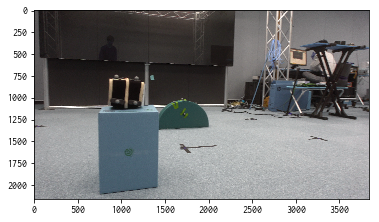

In [52]:
img = cv2.imread('KatoChairFrames/0425.png')
imshow(img)
show()

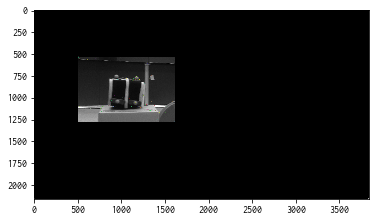

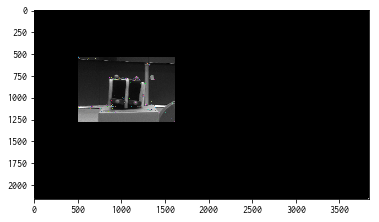

True

In [54]:
mask = cv2.imread('/Users/tatsu/Python/Multimodal/mask.jpg',0)
masked = cv2.bitwise_and(img,img,mask=mask)
gray = cv2.cvtColor(masked,cv2.COLOR_BGR2GRAY)
imshow(masked)
show()

sift = cv2.xfeatures2d.SIFT_create()
kp,comp = sift.detectAndCompute(gray,None)

img = cv2.drawKeypoints(gray,kp,None)
imshow(img)
show()

# imshow(img)
# show()
cv2.imwrite('sift_keypoints.jpg',img)

In [10]:
kp

[<KeyPoint 0x116a4ef00>,
 <KeyPoint 0x1109ac930>,
 <KeyPoint 0x1109ac870>,
 <KeyPoint 0x1109ac7b0>,
 <KeyPoint 0x1109ac9f0>,
 <KeyPoint 0x1109ac8a0>,
 <KeyPoint 0x1109aca20>,
 <KeyPoint 0x1109ac840>,
 <KeyPoint 0x1109ac8d0>,
 <KeyPoint 0x1109ac810>,
 <KeyPoint 0x1109ac990>,
 <KeyPoint 0x1109ac960>,
 <KeyPoint 0x1109ac7e0>,
 <KeyPoint 0x1109ac780>,
 <KeyPoint 0x1109aca50>,
 <KeyPoint 0x1109aca80>,
 <KeyPoint 0x1109acab0>,
 <KeyPoint 0x1109acae0>,
 <KeyPoint 0x1109acb10>,
 <KeyPoint 0x1109acb40>,
 <KeyPoint 0x1109acb70>,
 <KeyPoint 0x1109acba0>,
 <KeyPoint 0x1109acbd0>,
 <KeyPoint 0x1109acc00>,
 <KeyPoint 0x1109acc30>,
 <KeyPoint 0x1109acc60>,
 <KeyPoint 0x1109acc90>,
 <KeyPoint 0x1109accc0>,
 <KeyPoint 0x1109accf0>,
 <KeyPoint 0x1109acd20>,
 <KeyPoint 0x1109acd50>,
 <KeyPoint 0x1109acd80>,
 <KeyPoint 0x1109acdb0>,
 <KeyPoint 0x1109acde0>,
 <KeyPoint 0x1109ace10>,
 <KeyPoint 0x1109ace40>,
 <KeyPoint 0x1109ace70>,
 <KeyPoint 0x1109acea0>,
 <KeyPoint 0x1109aced0>,
 <KeyPoint 0x1109acf00>,


In [11]:
#img = cv2.imread('KatoChairFrames/0425.png')
#mask = cv2.imread('mask.jpg',0)
#masked = cv2.bitwise_and(img,img,mask=mask)
#gray = cv2.cvtColor(masked,cv2.COLOR_BGR2GRAY)
#gray = np.float32(gray)
#dst = cv2.cornerHarris(gray,1,3,0.5)
#masked[dst>0.01*dst.max()] = [0,0,255]

#imshow(masked)
#show()
# cv2.imwrite('harris_corner.jpg',img)

In [56]:
from scipy.ndimage import filters

def compute_harris_response(im,sigma=3):
    imx = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (0,1), imx)
    imy = zeros(im.shape)
    filters.gaussian_filter(im, (sigma,sigma), (1,0), imy)
    
    Wxx = filters.gaussian_filter(imx*imx,sigma)
    Wxy = filters.gaussian_filter(imx*imy,sigma)
    Wyy = filters.gaussian_filter(imy*imy,sigma)
    
    Wdet = Wxx*Wxy - Wxy**2
    Wtr = Wxx + Wyy
    
    return Wdet / Wtr

In [57]:
def get_harris_points(harrisim,min_dist=10,threshold=0.1):
    corner_threshold = harrisim.max() * threshold
    harrisim_t = (harrisim > corner_threshold) * 1
    
    coords = array(harrisim_t.nonzero()).T
    
    candidate_values = [harrisim[c[0],c[1]] for c in coords]
    
    index = argsort(candidate_values)
    
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_dist:-min_dist,min_dist:-min_dist] = 1
    
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i,0],coords[i,1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i,0]-min_dist):(coords[i,0]+min_dist),
                             (coords[i,1]-min_dist):(coords[i,1]+min_dist)] = 0
    
    return filtered_coords

In [58]:
def plot_harris_points(image,filtered_coords):
    figure()
    matplotlib.pyplot.gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'*')
    axis('off')
    cv2.imwrite('harris_points.jpg',image)
    show()

/Users/tatsu/miniconda3/envs/opencv/lib/python2.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in divide
  app.launch_new_instance()
/Users/tatsu/miniconda3/envs/opencv/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


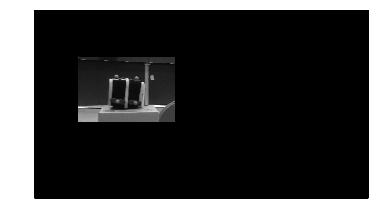

In [59]:
im = cv2.imread('KatoChairFrames/0425.png')
mask = cv2.imread('mask.jpg',0)
masked_im = cv2.bitwise_and(im,im,mask=mask)
grayed = cv2.cvtColor(masked_im,cv2.COLOR_BGR2GRAY)

harrisim = compute_harris_response(grayed)
filtered_coords = get_harris_points(harrisim,3)
plot_harris_points(grayed, filtered_coords)

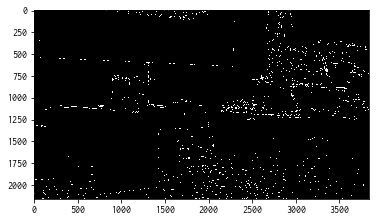

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486588158526/work/opencv-3.1.0/modules/imgproc/src/shapedescr.cpp:314: error: (-215) npoints >= 0 && (depth == CV_32F || depth == CV_32S) in function contourArea


In [16]:
im = cv2.imread('KatoChairFrames/0425.png')
grayed = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
edged = cv2.Canny(grayed, 50, 125)
mask = cv2.imread('mask.jpg',0)
masked_im = cv2.bitwise_and(edged,edged,mask=mask)
imshow(edged)
show()

cnts = cv2.findContours(masked_im.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
c = max(cnts, key = cv2.contourArea)

In [ ]:
objpoints = []
imgpoints = []

In [ ]:
for cp in kp:
   objpoints.append(cp.pt)
for cp in masked_im:
    imgpoints.append(cp.pt)

In [ ]:

objpoints = np.asarray(objpoints,dtype=float32)
imgpoints = np.asarray(masked_im,dtype=float32)
print(objpoints.dtype)
print(imgpoints.dtype)
print(objpoints.shape)
print(imgpoints.shape)



In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,filtered_coords,gray.shape[::-1],None,None)

In [ ]:
gray.shape[::-1]

In [60]:
def find_marker(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(gray, 35, 125)
    
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts[1], key=cv2.contourArea)
    
    return cv2.minAreaRect(c)

test = cv2.imread('test.jpg')
img = cv2.imread('KatoChairFrames/0429.png')
marker = find_marker(img)

def distances_to_camera(objWidth, focalLength, perWidth):
    return (objWidth*focalLength) / perWidth
    
print(distances_to_camera(objWidth, focalLength, marker[1][0]))
marker[1][0]

15.1599429344


35.38000202178955

In [ ]:
objDistance = 15.0
objWidth = 20.0
focalLength = (marker[1][0]*objDistance) / objWidth

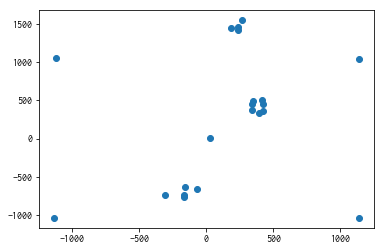

In [93]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt.scatter(motion_data_pd.X, motion_data_pd.Y)

In [14]:
motion_data_pd = motion_data_pd.drop(motion_data_pd.index[[4,8,9,10,11]])

0      337.457031
1     -163.618866
2      342.558441
3      421.193909
4     1136.197632
5      -66.671730
6     -303.008209
7      422.279602
8     1135.446899
9       28.382595
10   -1117.921875
11   -1130.083984
12     186.786789
13     233.976776
14    -160.992584
15     396.148193
16     233.323608
17     268.498566
18     350.733185
19     418.836334
20    -161.817123
Name: X, dtype: float64
0     337.457031
1    -163.618866
2     342.558441
3     421.193909
5     -66.671730
6    -303.008209
7     422.279602
12    186.786789
13    233.976776
14   -160.992584
15    396.148193
16    233.323608
17    268.498566
18    350.733185
19    418.836334
20   -161.817123
Name: X, dtype: float64


In [14]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3, random_state=0).fit(motion_data_pd)

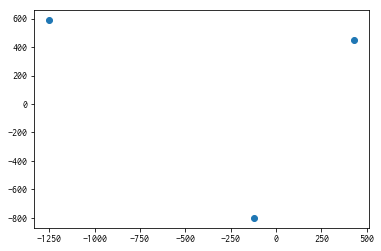

In [15]:
centroids = kmeans.cluster_centers_
plt.scatter(centroids[:,:1], centroids[:,1:2])

In [16]:
centroids

array([[-1249.13769531,   587.97255249,   379.79557676],
       [  428.07258203,   446.88673867,   316.48362859],
       [ -121.6138164 ,  -799.65935407,   140.837999  ]])

In [17]:
def distance(p1, p2):
    """calculate euclidian distance of two points"""
    return np.sqrt((p1[0] - p2[0])**2 + (p2[1] - p2[1])**2)

In [18]:
def distance_from_motion(data):
    """calculate 2D distance from motion data"""
    distances = []
    kmeans = KMeans(n_clusters=3, random_state=0).fit(data)
    centroids = kmeans.cluster_centers_
    distances.append(distance(centroids[0,:2],centroids[1,:2]))
    distances.append(distance(centroids[0,:2],centroids[2,:2]))
    return distances

In [19]:
def remove_marker_data(data):
    """remove marker data from motion data"""
    data = data.drop(data.index[[4,8,9,10,11]])
    return data

In [20]:
for n in range(len(motion_data)):
    motion_data_pd = pd.DataFrame(data=motion_data[n],columns=['X', 'Y', 'Z'])
    remove_marker_data(motion_data_pd)
    print(distance_from_motion(motion_data_pd))

[1677.2102773454453, 1127.5238789149694]
[1677.2110574934218, 1127.5220079694475]
[1677.2571041954889, 1127.5391983032225]
[1677.2572365654837, 1127.5351996285572]
[1677.2519858466258, 1127.5270165579659]
[1677.242795859443, 1127.531953212193]
[1677.2131391313339, 1127.495807320731]
[1677.216040717231, 1127.4986125401088]
[1677.1920842912464, 1127.4942810058594]
[1677.1893272823759, 1127.4897672380721]
[1677.1867963578966, 1127.4775593348911]
[1677.174290974935, 1127.4745864868164]
[1677.1781838311092, 1127.4770405360632]
[1677.1755399915905, 1127.477835736956]
[1677.1748179117837, 1127.4795987810405]
[1677.188550016615, 1127.4827730451311]
[1677.1836770799425, 1127.4824386596679]
[1677.1840854644774, 1127.4800626482281]
[1677.1798174964056, 1127.4838766915454]
[1677.1811377631293, 1127.4852942330497]
[1677.1925740136041, 1127.4951448713032]
[1677.1941274854873, 1127.4919747488839]
[1677.1919518364803, 1127.4855137416296]
[1677.2000698089601, 1127.5011548723494]
[1677.1856797112359, 11

[1575.4157602522107, 1025.7833121163503]
[1573.3950790405272, 1023.7753662109374]
[1571.4963829888238, 1021.8561680385045]
[1569.5162031385635, 1019.888671875]
[1567.576350953844, 1017.9394378662109]
[1565.6092800988092, 1015.9845781598772]
[1563.6426380581327, 1014.0063112531391]
[1561.6936033884685, 1012.0588169642858]
[1559.6932504865858, 1010.0617407662529]
[1557.7571064419215, 1008.1257213047571]
[1555.7902963426377, 1006.1610685076032]
[1553.8399336920845, 1004.1991465977261]
[1551.8678639729819, 1002.2351063319614]
[1549.8255912780762, 1000.1929515293667]
[1548.0127126481798, 998.38891448974618]
[1546.0357451968723, 996.39807019914895]
[1544.0600136650933, 994.42982918875555]
[1542.082164679633, 992.45771702357695]
[1540.1636110517713, 990.55139770507822]
[1538.279770406087, 988.64731794084798]
[1536.1753778245716, 986.52867540631973]
[1534.409663433499, 984.75463888985769]
[1532.3089291042752, 982.65567866734102]
[1530.1613538106285, 980.50813467843204]
[1528.2922585381402, 978

[1377.2031535678439, 827.62482844761428]
[1376.6055921766492, 827.02421766008649]
[1375.8777868058946, 826.28515254429408]
[1375.172334882948, 825.58305794852117]
[1374.443625301785, 824.85511409214575]
[1373.7780659569632, 824.20034746442514]
[1373.0747379726831, 823.49510519845137]
[1372.0897062513566, 822.51391754150404]
[1371.3425582885743, 821.76522347586501]
[1370.5755204942488, 820.99121180943064]
[1369.7632692548964, 820.17499040876123]
[1368.7460670895045, 819.15738721575053]
[1367.9443296644426, 818.3676864624025]
[1367.2144822862415, 817.64183894566145]
[1366.2335995568167, 816.66192735944469]
[1365.3279635959202, 815.74995727539067]
[1364.4692887624105, 814.88588104248049]
[1363.5554354773626, 813.9706865583147]
[1362.6142488267687, 813.02869437081472]
[1361.6753240373398, 812.10454690115785]
[1360.705194812351, 811.12836914062507]
[1359.7495716942681, 810.16073717389781]
[1358.6377235836453, 809.06767142159606]
[1357.6144182417127, 808.03874642508367]
[1356.6883627997504, 

[1112.065758090549, 562.41453356061652]
[1111.0414823320177, 561.38789847237717]
[1110.0656330956353, 560.41863098144529]
[1109.0953045739066, 559.44027470179958]
[1108.0366552140979, 558.38219233921598]
[1106.9638578202992, 557.31386958530982]
[1106.0343065473767, 556.37089669363831]
[1105.092344326443, 555.43291734967909]
[1104.0273005167642, 554.37271336146762]
[1102.9824363284638, 553.32494942801338]
[1102.086329820421, 552.43398001534592]
[1101.0411178588868, 551.3892198835099]
[1099.9920327504476, 550.32308371407657]
[1099.0011485205755, 549.33267735072548]
[1097.9834824879963, 548.32409144810265]
[1096.8726999070909, 547.20885423932759]
[1095.7176569196913, 546.06389007568362]
[1094.6833438449435, 545.01480712890623]
[1093.6645647684736, 543.99446977887851]
[1092.513380432129, 542.84755445207873]
[1091.4010306888154, 541.73207462855748]
[1090.4368954552544, 540.75752890450622]
[1089.4261481814915, 539.77507106236044]
[1088.3409822252061, 538.68772016252785]
[1087.3884286244711, 

[430.67437918526781, 980.34149801466197]
[429.99272417340961, 979.65194875929092]
[429.52473340715676, 979.18980005052344]
[428.96537301199777, 978.63189290364562]
[428.41555262974339, 978.08541331821016]
[427.89915444510319, 977.55600217183428]
[427.37113952636719, 977.0323126051162]
[426.84804861886164, 976.50552537706176]
[426.34050162179142, 975.99826766120054]
[425.87303379603793, 975.54484833611389]
[425.41429443359374, 975.08890245225689]
[425.01930258614686, 974.68739140828438]
[424.60625762939458, 974.27604577806267]
[424.0588450840541, 973.71871350606273]
[423.57103118896487, 973.23835716247572]
[423.13561379568921, 972.79617958068843]
[422.64254215785434, 972.31196467081713]
[422.17375313895099, 971.83231684366854]
[421.76357182094023, 971.42506209479416]
[421.37597743443087, 971.04310807122147]
[420.92831420898438, 970.60305171542711]
[420.51046098981584, 970.18039766947436]
[420.117843409947, 969.78078575134282]
[419.65249873570031, 969.31888783772786]
[419.19430367606026,

[314.14392046247207, 863.80241644117564]
[313.6203593662807, 863.28779572380904]
[313.18166220528735, 862.85656937493218]
[312.71440146309988, 862.38082813686788]
[312.33430633544918, 862.00130085415299]
[311.91135297502797, 861.57483185662181]
[311.42350354875839, 861.07945942348897]
[310.90550951276504, 860.56796917385509]
[310.55110931396484, 860.22158304850268]
[310.08515167236328, 859.7561709086101]
[309.57261090959827, 859.22179887559685]
[309.10414864676341, 858.76202909681535]
[308.62045353480744, 858.27657419840489]
[308.0402790614537, 857.70568839179157]
[307.48205544607987, 857.14349606831877]
[306.73933606828962, 856.40599174499516]
[306.18036084856305, 855.84565552605522]
[305.59952850341801, 855.25526203579375]
[304.93651079450331, 854.59587779574906]
[304.35114767892026, 854.01713587443055]
[303.65136740548263, 853.31661682128902]
[303.05631147112166, 852.71960830688488]
[302.47034563337053, 852.13461028205029]
[301.77645634242464, 851.43990885416679]
[301.19839368547719

[92.995579157556818, 642.6620480351977]
[91.866256535053253, 641.53118624289823]
[90.941415817397001, 640.60110310183632]
[89.856779691151161, 639.52262565294905]
[88.911144951411671, 638.58619262907246]
[87.78723027365551, 637.45077046288384]
[86.705211462293363, 636.36425345738735]
[85.702104936327274, 635.35857973098769]
[84.543694063595424, 634.20901041825618]
[83.672029120581485, 633.33871446715466]
[82.585535727228461, 632.25098671648232]
[81.664888378551993, 631.32271415127661]
[80.651177324567513, 630.30800382826055]
[79.613857861927556, 629.27726792759381]
[78.59957457951144, 628.25392873552119]
[77.681496715545677, 627.35205437342324]
[76.843637180328415, 626.50765750673088]
[76.055579703194724, 625.72111273871531]
[74.992438479832259, 624.65514918433291]
[74.146533748081694, 623.8020342508953]
[73.332523863656149, 622.99991359710691]
[72.426421792166622, 622.09726134406196]
[71.624343354361429, 621.2827122370403]
[70.722431482587552, 620.39397360483815]
[69.886699186052596, 

[548.5967230796814, 1563.6248321533203]
[549.25294248263049, 1564.2889200846355]
[549.93721810976672, 1564.9652735392253]
[550.55351090431202, 1565.5947494506836]
[551.15462334950769, 1566.1961568196616]
[551.76422770818067, 1566.8017018636067]
[552.36381920178724, 1567.3988622029622]
[552.91151754061389, 1567.9579264322917]
[553.44412612915028, 1568.4848937988281]
[554.00927138328552, 1569.0464553833008]
[554.51385490099597, 1569.5546595255535]
[555.03614179293322, 1570.0844141642253]
[555.51096240679431, 1570.564058939616]
[556.03860092163086, 1571.0763931274414]
[556.56927235921228, 1571.610669453939]
[557.0786384741466, 1572.1223856608074]
[557.60630528132128, 1572.6400400797527]
[558.11540420850122, 1573.1489537556968]
[558.68267496426904, 1573.7040074666343]
[559.2294979095459, 1574.2573013305664]
[559.7872670491538, 1574.8118794759116]
[560.30638392766309, 1575.3488438924153]
[560.82221333185839, 1575.8706080118816]
[561.39628505706787, 1576.4210586547852]
[561.91277082761144, 1

[963.39046042306086, 664.18776596917041]
[964.48149414062505, 665.27904858059355]
[965.62624293736042, 666.42988188001834]
[966.70847821916857, 667.49813139173727]
[967.95420227050795, 668.75240287780775]
[969.06820024762828, 669.86534669664172]
[970.39398171561106, 671.18779445224334]
[971.5028490339007, 672.30287445916065]
[972.82331739153176, 673.61673630608459]
[974.00523594447543, 674.80115720960828]
[975.27395520891457, 676.07240782843701]
[976.42624402727392, 677.22669130961094]
[977.7601255144391, 678.55359450446235]
[979.08591613769522, 679.8871680789523]
[980.48677019391732, 681.29172511630588]
[981.9247918265205, 682.7190536075168]
[983.3663561139789, 684.16872503492573]
[985.06261640276239, 685.8618056827122]
[986.68343353271484, 687.47744878133142]
[988.29931117466526, 689.10029529995393]
[989.96976688929965, 690.76206186082629]
[991.77331760951438, 692.57142194112134]
[993.47824532645086, 694.27600987752282]
[995.14363730294372, 695.9369823455811]
[996.85785587855742, 697

[1143.4609320504323, 844.59886148240821]
[1144.2338971819197, 845.36471616956931]
[1144.7323309762137, 845.85460743374301]
[1144.9609412057059, 846.08293516370986]
[1147.2727595738002, 848.40225791931152]
[1147.784123665946, 848.90729306538913]
[1148.2030711582729, 849.32894596523693]
[1148.1263885498047, 849.25983937581373]
[1148.4393624441966, 849.56750200059685]
[1148.6070885794502, 849.73233723110616]
[1150.1105045863562, 851.23376299540212]
[1149.8675146920341, 850.98921915690107]
[1150.7604548863001, 851.88815799289273]
[1150.7293786185128, 851.85566571553545]
[1151.6182593209403, 852.7509058210585]
[1152.1062214442663, 853.2355227576362]
[1152.7109115600588, 853.84490047030999]
[1153.1777058192663, 854.29471130371098]
[1154.0386899675643, 855.16607636345771]
[1154.4223547799245, 855.56101769341353]
[1154.6860146658762, 855.82166112263997]
[1155.2229160853794, 856.35589752197257]
[1155.9484721592494, 857.07457563612184]
[1156.6036477225166, 857.73502235412593]


ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [ ]:
motion_data_pd = pd.DataFrame(data=motion_data[11],columns=['X', 'Y', 'Z'])
remove_marker_data(motion_data_pd)
kmeans = KMeans(n_clusters=3, random_state=0).fit(motion_data_pd)
centroids = kmeans.cluster_centers_
print(distance(centroids[1,:2],centroids[2,:2]))

In [ ]:
focalLength = (marker[1][0]*objDistance) / objWidth

In [ ]:
objDistance = 15.0
objWidth = 20.0

def find_marker(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5,5), 0)
    edged = cv2.Canny(gray, 35, 125)
    imshow(edged)
    show()
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    c = max(cnts[1], key=cv2.contourArea)
    
    return cv2.minAreaRect(c)

img = cv2.imread('KatoChairFrames/0300.png')
marker = find_marker(img)

def distances_to_camera(objWidth, focalLength, perWidth):
    return (objWidth*focalLength) / perWidth
    
print(distances_to_camera(objWidth, focalLength, marker[1][0]))